### Adaptive AI Retrieval and Generation Pipeline for Enhanced Responsiveness and Scalability

#### Project Goals
1. Integrate Local and External Data: The system can pull information from local documents and perform web searches to gather relevant data. 
2. Dynamic Query Handling: It starts with a user query, checks if it can be answered from existing knowledge, and if not, retrieves additional data. 
3. Context Building: The retrieved data is compiled into a coherent context before generating a final answer. 
4. Enhanced Decision-Making: The agentic AI makes decisions about which information to retrieve based on the query, allowing for more tailored responses.

### Import Required Libraries

In [ ]:

import time, requests, os
from langchain.agents import AgentExecutor, create_openai_functions_agent, create_openai_tools_agent, create_tool_calling_agent
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, AnyMessage
from langchain.agents import AgentExecutor, tool, create_react_agent
from langchain_core.tools import tool
from langchain.tools import Tool
from langchain_core.messages.tool import ToolMessage
from langchain.schema import HumanMessage, SystemMessage, AIMessage
import functools

from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages




from typing import List, Dict
from typing import Annotated, Sequence
from typing_extensions import TypedDict

### Initialize the Language Model

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

#### 1. Preprocess documents
- Fetch documents to use in our RAG system.
- Split the fetched documents into smaller chunks for indexing into our vectorstore

In [5]:
# fetch doc
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

In [7]:
docs[0][0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use c

In [8]:
# split the doc
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, 
    chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [9]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

#### 2. Create a retriever tool
We have our split documents, we can index them into a vector store that we'll use for semantic search.

1. Use an in-memory vector store and OpenAI embeddings
2. Create a retriever tool using LangChain's prebuilt create_retriever_tool

In [ ]:
# embedding and vectorestore
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [12]:
# create a retriever tool
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever = retriever,
    name = "retrieve_blog_posts",
    description = "Search and return information about Lilian Weng blog posts."
    )

# test the retriever tool

retriever_tool.invoke({"query": "types of reward hacking"})

[{'object': 'embedding', 'index': 0, 'embedding': [-0.012890519, -0.022141153, -0.020472132, -0.008007746, -0.012260197, 0.017888702, -0.035972714, 0.008722407, -0.013582985, 0.047300745, 0.005490899, -0.01841249, 0.0039506066, -0.017995235, -0.0012362291, -0.00072076375, 0.016770104, -0.0047718002, 0.020827243, -0.0045321, 0.018980667, -0.0038152207, -0.021626242, -0.009445945, 0.009765544, -0.0101739215, -0.020472132, -0.013245629, -0.034019604, 0.025745526, 0.022371974, 0.02123562, -0.013343285, -0.001682337, 0.047052167, -0.03410838, 0.019957222, -0.035777405, 0.024733461, 0.004108187, -0.0050914, -0.023330774, -0.032989785, -0.030983409, -0.011239254, 0.030770343, 0.013565229, -0.028728455, -0.010165044, -0.026970658, 0.014985672, 0.030947898, -0.0065162815, 0.010404743, -0.009419312, 0.0067471033, 0.023206485, -0.0077103414, -0.002843105, 0.00069246587, 0.0066805203, 0.017950846, 0.0090642, -0.0005237883, 0.0056018713, -0.05138452, -0.013654007, 0.059481043, 0.003431257, 0.029971

'Detecting Reward Hacking#\n\nWhy does Reward Hacking Exist?#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.'

### Create Agent:
- Now we will start building components (nodes and edges) for our agentic RAG graph.
- The components will operate on the MessagesState — graph state that contains a messages key with a list of chat messages.

#### 3. Generate query node/agent
- Build a generate_query_or_respond node. 
- It will call an LLM to generate a response based on the current graph state (list of messages). 
- Given the input messages, it will decide to retrieve using the retriever tool, or respond directly to the user. 
- We're giving the chat model access to the retriever_tool we created earlier via .bind_tools

In [ ]:
# generate_query_or_respond node/agent
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("openai:gpt-4.1", temperature=0)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}


In [14]:
# try generate_query_or_respond node/agent on a random input
input = {"messages": [{"role": "user", 
         "content": "hello!"}]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [15]:
# ask a question from generate_query_or_respond node/agent that requires semantic search
input = {
    "messages": [
        {"role": "user",
        "content": "What does Lilian Weng say about types of reward hacking?"
        }
    ]
}

generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_p4jaoaCUHmPvpMdZ1ZyjoZwT)
 Call ID: call_p4jaoaCUHmPvpMdZ1ZyjoZwT
  Args:
    query: types of reward hacking


#### 4. Grade documents (conditional edge)
- Add a conditional edge — grade_documents — to determine whether the retrieved documents are relevant to the question. 
- We will use a model with a structured output schema GradeDocuments for document grading. 
- The grade_documents function will return the name of the node to go to based on the grading decision (generate_answer or rewrite_question)

In [16]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

In [ ]:
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description = "Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

grader_model = init_chat_model("openai:gpt-4.1", temperature=0)

def grade_documents(state: MessagesState) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question = question, context = context)
    response = (
        grader_model.with_structured_output(GradeDocuments).invoke(
            [{"role": "user",
              "content": prompt}]
        )
    )

    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [18]:
# run this with irrelevant documents in the tool response
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [19]:
# confirm that the relevant documents are classified as such
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'rewrite_question'

#### 5. Rewrite question node/agent
- Build the rewrite_question node. 
- The retriever tool can return potentially irrelevant documents, which indicates a need to improve the original user question. 
- To do so, we will call the rewrite_question node

In [20]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]    
    question = messages[0].content      # Input: The original question from the user
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [21]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

Could you provide a summary or explanation of Lilian Weng's views on the different types of reward hacking in AI systems?


#### 6. Generate an answer node/agent
- If we pass the grader checks, we can generate the final answer based on the original question and the retrieved context

In [22]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    messages = state["messages"] 
    question = messages[0].content
    context = messages[-1].content  # Uses retrieved context to answer the question
    prompt = GENERATE_PROMPT.format(question = question, context = context)     # Input: the original question + Retrieved context
    response = response_model.invoke([{"role": "user",
                                      "content": prompt}])
    return {"messages": [response]}
    

In [23]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecification, and reward tampering.


#### 7. Create and assemble the graph
- Start with a generate_query_or_respond and determine if we need to call retriever_tool
- Route to next step using tools_condition:
    - If generate_query_or_respond returned tool_calls, call retriever_tool to retrieve context
    - Otherwise, respond directly to the user
- Grade retrieved document content for relevance to the question (grade_documents) and route to next step:
    - If not relevant, rewrite the question using rewrite_question and then call generate_query_or_respond again
    - If relevant, proceed to generate_answer and generate final response using the ToolMessage with the retrieved document context

In [24]:
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


Graph = StateGraph(MessagesState)

# Define the nodes we will cycle between
Graph.add_node(generate_query_or_respond)
Graph.add_node("retrieve", ToolNode([retriever_tool]))
Graph.add_node(rewrite_question)
Graph.add_node(generate_answer)

In [25]:
# Define the nodes
Graph.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
Graph.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,            # tools_condition is a routing function based on the agent's intent
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",   # If the agent needs tools (like a retriever), it returns "tools".
        END: END,              # If the agent can respond directly, it returns END.
    },
)


# Edges taken after the `action` node is called.
Graph.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

Graph.add_edge("rewrite_question", "generate_query_or_respond")
Graph.add_edge("generate_answer", END)

# Compile
graph = Graph.compile()

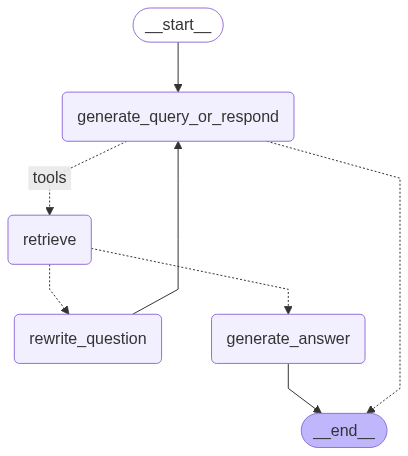

In [26]:
# Visualize the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
# 8. Run the agentic RAG
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    },
    config={"recursion_limit": 50}  # Increase from default 25
):
    for node, update in chunk.items():
        print("Update from node", node)
        print(update["messages"][-1])
        print("\n\n")


Update from node generate_query_or_respond
content='' additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query":"types of reward hacking"}', 'name': 'retrieve_blog_posts'}, 'id': 'call_R5hUAjvnujZtqJPANcebw8Qd', 'type': 'function'}]} response_metadata={'usage_metadata': {'total_tokens': 91, 'completion_tokens': 72, 'prompt_tokens': 19}, 'model_name': 'gpt-4o', 'finish_reason': 'stop'} id='run-7d3524ff-b57a-431f-94d3-10fa52c59570-0' tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of reward hacking'}, 'id': 'call_R5hUAjvnujZtqJPANcebw8Qd', 'type': 'tool_call'}]



[{'object': 'embedding', 'index': 0, 'embedding': [-0.012890519, -0.022141153, -0.020472132, -0.008007746, -0.012260197, 0.017888702, -0.035972714, 0.008722407, -0.013582985, 0.047300745, 0.005490899, -0.01841249, 0.0039506066, -0.017995235, -0.0012362291, -0.00072076375, 0.016770104, -0.0047718002, 0.020827243, -0.0045321, 0.018980667, -0.0038152207, -0.021626242, -0.009445945, 0.009765544, -0